# Optimized+augmented PyTorch RGB CNN

In this notebook, we train the winning CNN architecture from the Optuna run in notebook 04 on the CIFAR-10 dataset with image augmentation for improved generalization.

## Notebook set-up

### Imports

In [ ]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Package imports
from cifar10_tools.pytorch.data import make_data_loaders
from cifar10_tools.pytorch.evaluation import evaluate_model
from cifar10_tools.pytorch.hyperparameter_optimization import create_cnn
from cifar10_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves
)
from cifar10_tools.pytorch.training import train_model

# Suppress Optuna info messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [ ]:
epochs = 100
print_every = 5

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

In [ ]:
# Load best hyperparameters from Optuna study
storage_path = Path('../data/pytorch/cnn_optimization.db')
storage_url = f'sqlite:///{storage_path}'

study = optuna.load_study(
    study_name='cnn_optimization',
    storage=storage_url
)

best_params = study.best_trial.params
batch_size = best_params['batch_size']

print('Loaded best hyperparameters from Optuna study:')

for key, value in best_params.items():
    print(f'  {key}: {value}')

print(f'\nBest validation accuracy from optimization: {study.best_trial.value:.2f}%')

print(f'Using batch size: {batch_size}')

Loaded best hyperparameters from Optuna study:
  n_conv_blocks: 3
  initial_filters: 128
  fc_units_1: 2048
  fc_units_2: 256
  dropout_rate: 0.30468763769815355
  use_batch_norm: True
  learning_rate: 0.04674148624351197
  optimizer: SGD
  sgd_momentum: 0.8921035323388053

Best validation accuracy from optimization: 87.96%


## 1. Load and preprocess CIFAR-10 data with augmentation

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes. We use RGB images with data augmentation to improve model generalization.

In [ ]:
# Make sure data directory exists
data_dir = Path('../data/pytorch/cifar10')
data_dir.mkdir(parents=True, exist_ok=True)

# Training transform with augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Validation/test transform (no augmentation)
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print('Training augmentations:')
print('  - Random horizontal flip (p=0.5)')
print('  - Random rotation (±15°)')
print('  - Random translation (±10%)')
print('  - Color jitter (brightness, contrast, saturation)')

# Create data loaders with augmentation (device=None for on-the-fly augmentation)
train_loader, val_loader, test_loader = make_data_loaders(
    data_dir=data_dir,
    batch_size=batch_size,
    train_transform=train_transform,
    eval_transform=eval_transform,
    device=None
)

print(f'\nTraining batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training augmentations:
  - Random horizontal flip (p=0.5)
  - Random rotation (±15°)
  - Random translation (±10%)
  - Color jitter (brightness, contrast, saturation)


### 1.1. Visualize sample images (with augmentation)

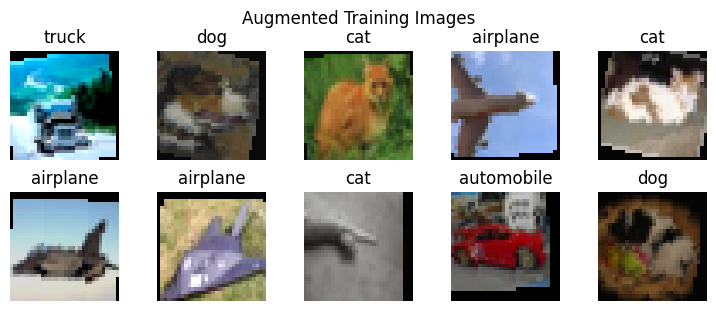

In [ ]:
# Get a sample dataset for visualization (with augmentation)
sample_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=False,
    transform=train_transform
)

# Plot first 10 images from the training dataset (augmented)
fig, axes = plot_sample_images(sample_dataset, class_names, nrows=2, ncols=5)
fig.suptitle('Augmented Training Images', y=1.02)
plt.show()

## 2. Build optimized CNN using best hyperparameters

We create a CNN using the best hyperparameters found during Optuna optimization, then train it with data augmentation.

### 2.2. Create model with best hyperparameters

In [ ]:
# Create model with best hyperparameters from Optuna
model = create_cnn(
    n_conv_blocks=best_params['n_conv_blocks'],
    initial_filters=best_params['initial_filters'],
    n_fc_layers=best_params['n_fc_layers'],
    base_kernel_size=best_params['base_kernel_size'],
    conv_dropout_rate=best_params['conv_dropout_rate'],
    fc_dropout_rate=best_params['fc_dropout_rate'],
    pooling_strategy=best_params['pooling_strategy'],
    use_batch_norm=best_params['use_batch_norm']
).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params:,}')

Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.30468763769815355, inplace=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.30468763769815355, inplace=False)
  (16)

### 2.3. Define loss function and optimizer

In [10]:
criterion = nn.CrossEntropyLoss()

# Create optimizer with best hyperparameters
if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

elif best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(
        model.parameters(), 
        lr=best_params['learning_rate'],
        momentum=best_params.get('sgd_momentum', 0.9)
    )

else:  # RMSprop
    optimizer = optim.RMSprop(model.parameters(), lr=best_params['learning_rate'])

print(f"Optimizer: {best_params['optimizer']}")

Optimizer: SGD


### 2.4. Train model

In [11]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    print_every=print_every,
    device=device  # Enable per-batch GPU transfer
)

Epoch 1/100 - loss: 2.0796 - accuracy: 21.45% - val_loss: 2.5523 - val_accuracy: 9.90%
Epoch 5/100 - loss: 1.2870 - accuracy: 52.75% - val_loss: 1.1075 - val_accuracy: 59.41%
Epoch 10/100 - loss: 0.9424 - accuracy: 66.73% - val_loss: 1.0135 - val_accuracy: 66.45%
Epoch 15/100 - loss: 0.7607 - accuracy: 73.15% - val_loss: 0.6263 - val_accuracy: 77.69%
Epoch 20/100 - loss: 0.6526 - accuracy: 77.12% - val_loss: 0.5555 - val_accuracy: 80.81%
Epoch 25/100 - loss: 0.5798 - accuracy: 79.64% - val_loss: 0.5119 - val_accuracy: 82.28%
Epoch 30/100 - loss: 0.5256 - accuracy: 81.53% - val_loss: 0.4760 - val_accuracy: 83.40%
Epoch 35/100 - loss: 0.4764 - accuracy: 83.24% - val_loss: 0.4869 - val_accuracy: 83.23%
Epoch 40/100 - loss: 0.4437 - accuracy: 84.54% - val_loss: 0.3901 - val_accuracy: 86.50%
Epoch 45/100 - loss: 0.4035 - accuracy: 85.92% - val_loss: 0.4228 - val_accuracy: 85.70%
Epoch 50/100 - loss: 0.3770 - accuracy: 86.88% - val_loss: 0.4575 - val_accuracy: 85.16%
Epoch 55/100 - loss: 0.3

### 2.5. Learning curves

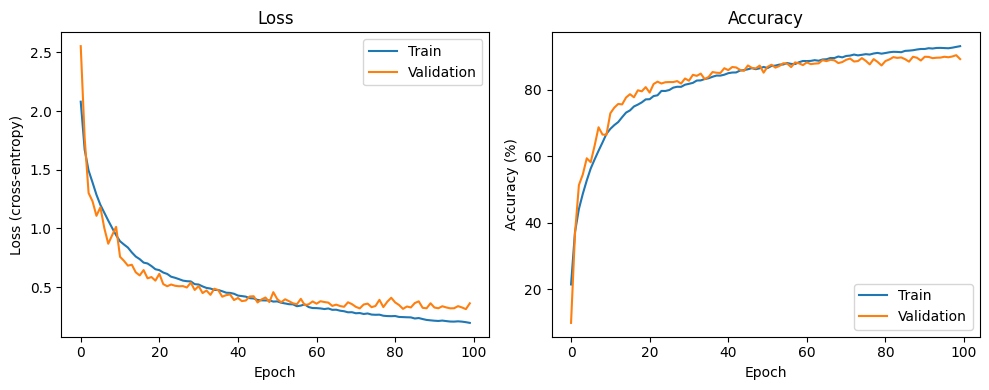

In [12]:
fig, axes = plot_learning_curves(history)
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [13]:
# Custom evaluation with per-batch GPU transfer
model.eval()
predictions = []
true_labels = []
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 89.30%


### 3.2. Per-class accuracy

In [14]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 90.00%
automobile  : 92.40%
bird        : 80.30%
cat         : 71.90%
deer        : 90.50%
dog         : 87.60%
frog        : 97.60%
horse       : 92.90%
ship        : 93.30%
truck       : 96.50%


### 3.3. Confusion matrix

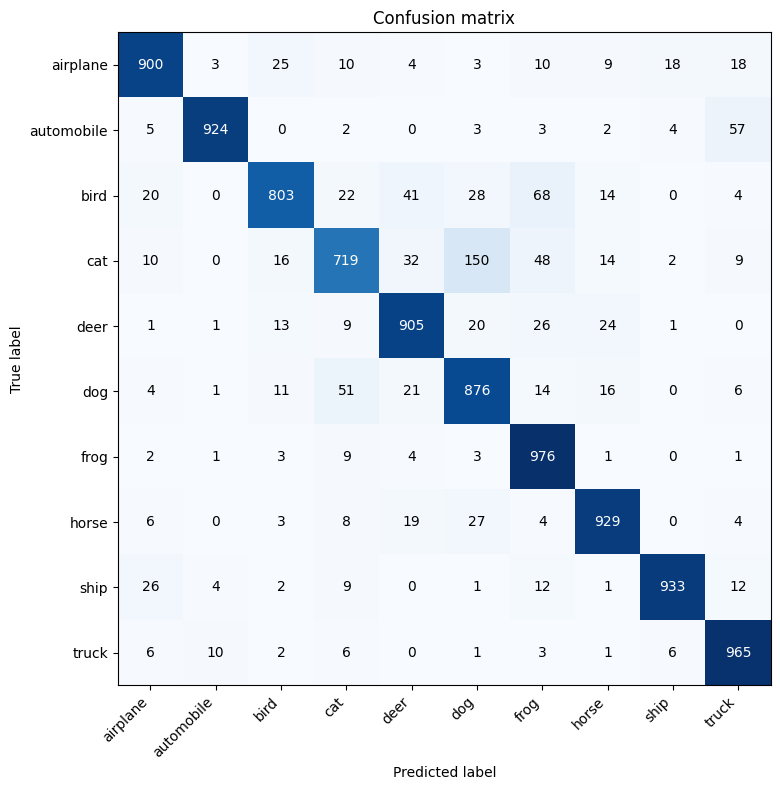

In [15]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 3.4. Predicted class probability distributions

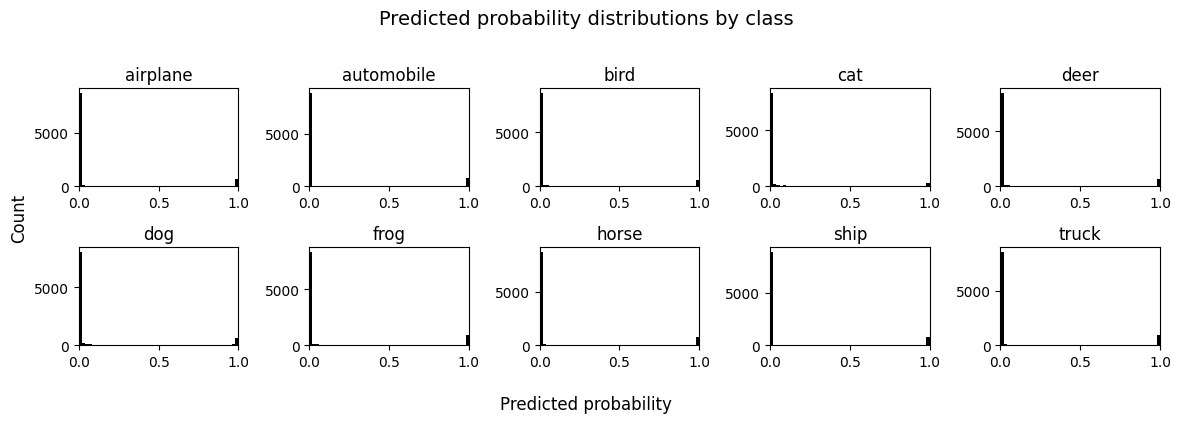

In [16]:
# Get predicted probabilities for all test samples
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 3.5. Evaluation curves

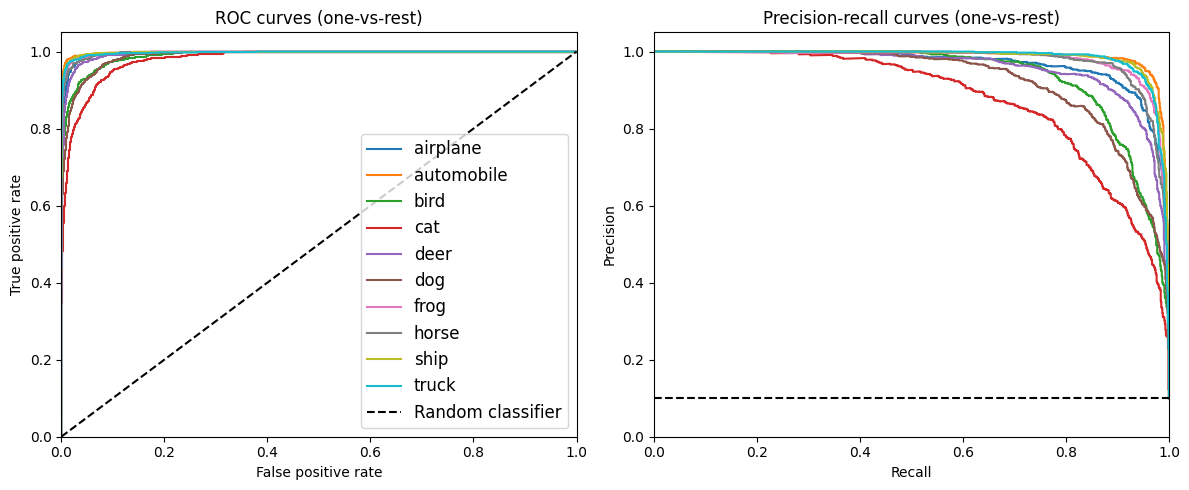

In [17]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 4. Save model

In [ ]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'augmented_cnn.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/augmented_cnn.pth
Test accuracy: 89.30%


: 